[62 序列到序列学习](https://www.bilibili.com/video/BV16g411L7FG/?spm_id_from=trigger_reload&vd_source=1d3a7b81d826789081d8b6870d4fff8e)
- seq2seq

典型应用场景机器翻译，一个句子到另一个句子，允许不同长度

<img src="picture/屏幕截图 2022-06-16 003407.png">

seq2seq采用一个rnn作为编码器，一个rnn作为解码器

<img src="picture/屏幕截图 2022-06-16 004107.png">

解码器训练好的隐藏层参数，将继续传递给编码器的隐藏层，作为其初试状态
- 具体实现看代码

<img src="picture/屏幕截图 2022-06-16 005606.png">

In [1]:
import collections
import math
import torch
from d2l import torch as d2l
from torch import nn

In [2]:

class Encoder(nn.Module):
    """The base encoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

In [3]:
class Decoder(nn.Module):
    """The base decoder interface for the encoder-decoder architecture.

    Defined in :numref:`sec_encoder-decoder`"""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [4]:
class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture.

    Defined in :numref:`sec_encoder-decoder`"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

这里说一下概念：编码解码器的原理是，先作为一个整体去训练，训练完后，编码解码的中间层作为输出！这个观点很重要
- 如果是编码器训练完后，再交给解码器训练，那么隐藏层根本没有检验的东西，无法训练
- 如果是编码器解码器统一训练，以实际结果为准，那么本身又等效于一个大的网络了
- 以上两种理解都是不对的

In [5]:
class Seq2SeqEncoder(Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size) # 输入是vocab，输出编码器size
        # GRU模型，这里其实可以选择多种模型
        # 参数依次是输入数据shape，隐藏层神经元个数，隐藏层数
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)
    
    # encoding是没有输出层的，不需输出最终结果
    def forward(self, X, *args):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state[0]的形状:(num_layers,batch_size,num_hiddens)
        return output, state

编码器实例化
- 补充说明：model的eval方法主要是针对某些在train和predict两个阶段会有不同参数的层。
- 比如Dropout层和BN层Dropout在train时随机选择神经元而predict要使用全部神经元并且要乘一个补偿系数BN在train时每个batch做了不同的归一化因此也对应了不同的参数，相应predict时实际用的参数是每个batch下参数的移动平均。
- torch为了方便大家，设计这个eval方法就是让我们可以不用手动去针对这些层做predict阶段的处理(也可以叫evaluation阶段,所以这个方法名才是eval)
- 这也就是说，如果模型中用了dropout或bn，那么predict时必须使用eval 否则结果是没有参考价值的，不存在选择的余地。

In [6]:
encoder = Seq2SeqEncoder(vocab_size=10,embed_size=8,num_hiddens=16,num_layers=2)
encoder.eval()
# 这里4,7只是举例，实际上随便换
X = torch.zeros((4,7),dtype=torch.long)
output,state = encoder(X)
output.shape,state.shape

(torch.Size([7, 4, 16]), torch.Size([2, 4, 16]))

\begin{array}{ll}
            r_t = \sigma(W_{ir} x_t + b_{ir} + W_{hr} h_{(t-1)} + b_{hr}) \\
            z_t = \sigma(W_{iz} x_t + b_{iz} + W_{hz} h_{(t-1)} + b_{hz}) \\
            n_t = \tanh(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{(t-1)}+ b_{hn})) \\
            h_t = (1 - z_t) * n_t + z_t * h_{(t-1)}
        \end{array}

In [7]:
class Seq2SeqDecoder(Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 这里需要注意的是，Decoder的输入需要加上时间步数长度的输入，为啥这么做可以看forward
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        # 输出的vocabsize
        self.dense = nn.Linear(num_hiddens, vocab_size)
    
    # enc_outputs指的是之前的encoder的output,state，enc_outputs[1]也就专门指代state
    # 因为安装之前的定义，encoder训练好的隐藏层参数是要交给decoder继续使用的
    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        # 广播context，使其具有与X相同的num_steps
        # state[-1]就是输出层的最后一个时刻训练的结果，repeat是按时间部步数对其进行重复
        context = state[-1].repeat(X.shape[0], 1, 1)
        # 这里把x和隐藏层最后输出叠加起来作为新的输入
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state[0]的形状:(num_layers,batch_size,num_hiddens)
        return output, state

PyTorch中的repeat()函数可以对张量进行重复扩充。当参数只有两个时：（列的重复倍数，行的重复倍数）。1表示不重复当参数有三个时：（通道数的重复倍数，列的重复倍数，行的重复倍数）。



In [8]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
# 这里依旧是举例其用法
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
# 这里4 是batch_size，7是序列长度（时间步数），10是vocab_size，
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

### 损失函数
- 神经网络都需要定义损失函数，但是对于文本数据集，由于存在填充项，在计算损失函数的时候，应该将填充词元的预测排除在损失函数的计算之外。
- 为此，可以使用下面的sequence_mask函数 通过零值化屏蔽不相关的项， 以便后面任何不相关预测的计算都是与零的乘积，结果都等于零。

In [9]:
# 这个函数会利用上我们之前保留的vaild_len来作为
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(X)
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 2, 3],
        [4, 5, 6]])


tensor([[1, 0, 0],
        [4, 5, 0]])

In [10]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数
    想法就是通过一个全为1的weight矩阵去控制
    获取vaild_len后，
    """
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        # 损失函数
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        # 对每个样本返回loss
        return weighted_loss

代码检查

In [11]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))
# 第三个句子由于有效长度为0，所以直接变全0了

tensor([2.3026, 1.1513, 0.0000])

In [12]:
def grad_clipping(net, theta):
    """Clip the gradient.

    Defined in :numref:`sec_rnn_scratch`"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [13]:
# 训练
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                     xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            # 主要区别之处，输入输出带有valid_len
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            # 额外增加bos，接下来所有的句子均去掉头部，增加一个bos
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                          device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()      # 损失函数的标量进行“反向传播”
            grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

开炼！！！

loss 0.019, 24328.7 tokens/sec on cuda:0


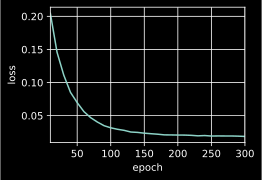

In [14]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [15]:
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences.

    Defined in :numref:`sec_machine_translation`"""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

In [16]:
# 创建预测函数
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    # 将句子token词元化，粒度为单词级别，末尾加上eos标识
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    # 记录句子有效长度
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    # 补齐或者裁剪句子长度
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    # 放入编码器
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

blue函数通过与真实的标签序列进行比较来评估预测序列

$$exp\left(\min\left(0, 1 - \frac{\mathrm{len}_{\text{label}}}{\mathrm{len}_{\text{pred}}}\right)\right) \prod_{n=1}^k p_n^{1/2^n}$$

In [17]:
def bleu(pred_seq, label_seq, k): 
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [18]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est malade ., bleu 0.658
i'm home . => je suis certain ., bleu 0.512
